In [14]:
import  numpy as np
import  torch
import  sklearn
import  tensorflow as tf
from    keras.datasets import cifar10
import  torchvision
import  torchvision.transforms as transforms

In [15]:
# Some trasformation on training data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomRotation(8,),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [16]:
batch_size = 32
epochs = 20
train_loss = np.zeros((epochs,))
val_loss = np.zeros((epochs,))
train_acc = np.zeros((epochs,))
val_acc = np.zeros((epochs,))


In [17]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
class MyModel(torch.nn.Module):
    def __init__(self, net, lr=0.001):
        super(MyModel, self).__init__()

        self.net = net

        self.batch_x_placeholder = torch.zeros(size=[1, 3, 224, 224], dtype=torch.float32, device=torch.device('cuda:0'))
        self.batch_y_placeholder = torch.zeros(size=[1], dtype=torch.long, device=torch.device('cuda:0'))

        self.optimizer = torch.optim.Adam(filter(
            lambda p: p.requires_grad, self.parameters()), 
            lr = lr
        )

    def forward(self, b_x, b_y=None):
        out = self.net(b_x)
        loss = -1 * torch.mean(out[torch.arange(b_x.shape[0]), b_y])
        decision = torch.argmax(out, dim=-1)
        return decision, loss

In [34]:
def evaluate(testset):
    with torch.no_grad():

        model.eval()  # validation phase

        predictions = []
        loss = 0
        corrects = 0
        total = 0

        iter = 1

        # iterating over the whole training set
        for b_x, b_y in testset:

            # resize placeholder
            if len(b_x) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(b_x), 3, 224, 224])
                batch_y_placeholder.resize_([len(b_x)])
        
            batch_x_placeholder.copy_(b_x)
        
            if b_y is not None:
                batch_y_placeholder.copy_(b_y)

            b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)

            b_decision = b_decision.cpu().numpy()

            loss += float(b_loss)
            corrects += np.sum(b_y.cpu().numpy() == b_decision)
            total += len(b_y)
            predictions.append(b_decision)

            if iter % 50 == 0:
                print(f'[Test] Iteration {iter:3d}. loss: {loss / iter:.4e} - accuracy: {corrects * 100.0 / total:.2f}')


            iter += 1

        accuracy = corrects * 100.0 / total
        loss /= (iter - 1)

        return np.concatenate(predictions), loss, accuracy


def save_parameters():
    #saving model
    torch.save({
            'epoch': e,
            'optimizer_state_dict': model.optimizer.state_dict(),
            'model_state_dict': model.state_dict(),
            'epoch_train_loss': epoch_train_loss,
            'epoch_train_accuracy': epoch_train_accuracy,
            'epoch_val_loss': epoch_val_loss,
            'epoch_val_accuracy': epoch_val_accuracy
        }, f'epoch_{e}_state.pt')

def train_model(trainset, batch_size = 32):
    
    model.train()  # training phase

    epoch_train_loss = 0
    corrects = 0
    total = 0
    iter = 1

    # iterate over training set
    for b_x, b_y in trainset:

        # resize placeholder
        if len(b_x) != len(batch_x_placeholder):
            batch_x_placeholder.resize_([len(b_x), 3, 224, 224])
            batch_y_placeholder.resize_([len(b_x)])
        
        batch_x_placeholder.copy_(b_x)
        if b_y is not None:
            batch_y_placeholder.copy_(b_y)

        b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)

        b_decision = b_decision.cpu().numpy()

        epoch_train_loss += float(b_loss)
        
        corrects += np.sum(b_y.cpu().numpy() == b_decision)
        total += len(b_y)

        if iter % 50 == 0:
            print(f'[Train] Iteration {iter:3d} - loss: {epoch_train_loss / iter:.4e} - accuracy: {corrects * 100.0 / total:.2f}')

        b_loss.backward()

        model.optimizer.step()
        model.optimizer.zero_grad()
        
        iter += 1

        epoch_train_accuracy = corrects * 100.0 / total
        epoch_train_loss /= (iter - 1)

    return epoch_train_loss, epoch_train_accuracy

In [35]:
def make_no_grad(module):
    for param in module.parameters():
        param.requires_grad_(False)

In [36]:
resnet = torchvision.models.resnet18(pretrained=True, progress=True)

# decider (FC)
resnet.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 10),
    torch.nn.LogSoftmax(dim=-1)
)

make_no_grad(resnet.conv1)
make_no_grad(resnet.layer1)
make_no_grad(resnet.layer2)

def inside_forward(x):
    with torch.no_grad():
        x = resnet.conv1(x)
        x = resnet.bn1(x)
        x = resnet.relu(x)
        x = resnet.maxpool(x)

      x = resnet.layer1(x)
    x = resnet.layer2(x)
    x = resnet.layer3(x)
    x = resnet.layer4(x)

    x = resnet.avgpool(x)
    x = resnet.fc(x.flatten(1))
    return x

resnet.forward = inside_forward


In [37]:
model = MyModel(torch.nn.DataParallel(resnet))

batch_x_placeholder = model.batch_x_placeholder
batch_y_placeholder = model.batch_y_placeholder
epochs = 20

In [38]:
from time import time

In [39]:
train_loss = np.zeros((epochs,))
val_loss = np.zeros((epochs,))
train_acc = np.zeros((epochs,))
val_acc = np.zeros((epochs,))

In [40]:
trainset, validationset = torch.utils.data.random_split(trainset, lengths=(int(len(trainset) * 0.8), int(len(trainset) * 0.2)))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=128, shuffle=False, num_workers=2)




for e in range(epochs):
    t_start = time()

    # train over dataset
    epoch_train_loss, epoch_train_accuracy = train_model(trainloader)
    train_loss[e] = epoch_train_loss
    train_acc[e] = epoch_train_accuracy

    # validating over validation set
    _, epoch_val_loss, epoch_val_accuracy = evaluate(validationloader)
    val_loss[e] = epoch_val_loss
    val_acc[e] = epoch_val_accuracy

    torch.save({
            'epoch': e,
            'optimizer_state_dict': model.optimizer.state_dict(),
            'model_state_dict': model.state_dict(),
            'epoch_train_loss': epoch_train_loss,
            'epoch_train_accuracy': epoch_train_accuracy,
            'epoch_val_loss': epoch_val_loss,
            'epoch_val_accuracy': epoch_val_accuracy
        }, f'epoch_{e}_state.pt')

    print(f'Epoch {e} finished in {time() - t_start:.2f}s - train loss: {epoch_train_loss:.4f} - acc: {epoch_train_accuracy:.2f} - val loss: {epoch_val_loss:.4f} - val acc: {epoch_val_accuracy:.2f}')
        


[Train] Iteration  50 - loss: 1.5901e-02 - accuracy: 67.30
[Train] Iteration 100 - loss: 5.6314e-03 - accuracy: 73.06
[Train] Iteration 150 - loss: 4.3435e-03 - accuracy: 75.68
[Train] Iteration 200 - loss: 2.5079e-03 - accuracy: 77.61
[Test] Iteration  50. loss: 6.9996e-01 - accuracy: 78.11
Epoch 0 finished in 90.32s - train loss: 0.0025 - acc: 77.61 - val loss: 0.7000 - val acc: 78.11
[Train] Iteration  50 - loss: 1.0772e-02 - accuracy: 84.81
[Train] Iteration 100 - loss: 6.1840e-03 - accuracy: 84.80
[Train] Iteration 150 - loss: 1.9642e-03 - accuracy: 84.94
[Train] Iteration 200 - loss: 9.9288e-04 - accuracy: 85.25
[Test] Iteration  50. loss: 4.8913e-01 - accuracy: 83.89
Epoch 1 finished in 89.54s - train loss: 0.0010 - acc: 85.25 - val loss: 0.4891 - val acc: 83.89
[Train] Iteration  50 - loss: 7.0933e-03 - accuracy: 88.67
[Train] Iteration 100 - loss: 4.6397e-03 - accuracy: 87.85
[Train] Iteration 150 - loss: 2.1283e-03 - accuracy: 88.02
[Train] Iteration 200 - loss: 1.7134e-03 - 

In [41]:
import matplotlib.pyplot as plt

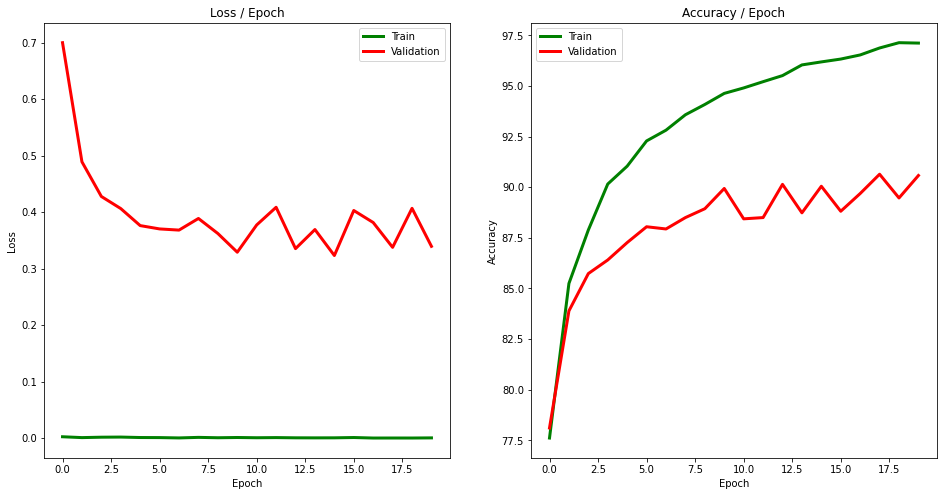

In [42]:
fig = plt.figure(figsize=(16, 8))


# loss
ax = fig.add_subplot(121)
ax.set_title('Loss / Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)


plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy / Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_acc, label='Train', color='green', linewidth=3)
plt.plot(val_acc, label='Validation', color='red', linewidth=3)


plt.legend()

In [43]:
predictions, test_loss, test_accuracy = evaluate(testloader)

[Test] Iteration  50. loss: 3.5494e-01 - accuracy: 91.67


In [45]:
test_accuracy

91.75

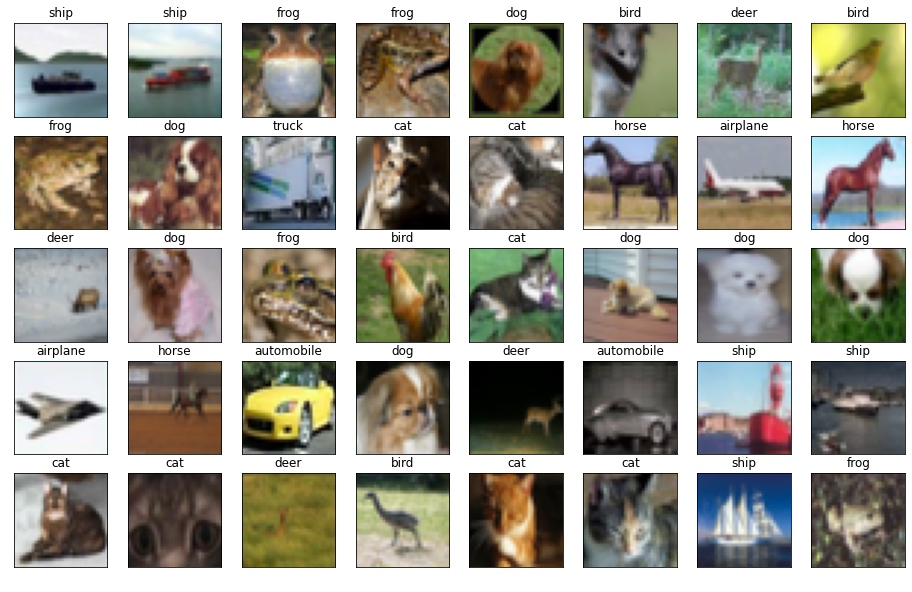

In [50]:
right_indices = predictions == np.array(testset.targets)
right_images = testset.data[right_indices]
right_labels = predictions[right_indices]
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
choosen_indices = np.random.choice(np.arange(len(right_images)), size=40)

images = right_images[choosen_indices]
label_predictions = right_labels[choosen_indices]
texts = [f'{labels[label_predictions[i]]}' for i in range(len(choosen_indices))]


columns = 8
rows = 5
fig = plt.figure(figsize=(2 * columns, 2 * rows))

for i in range(columns * rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title(texts[i])
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(images[i])

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.show()

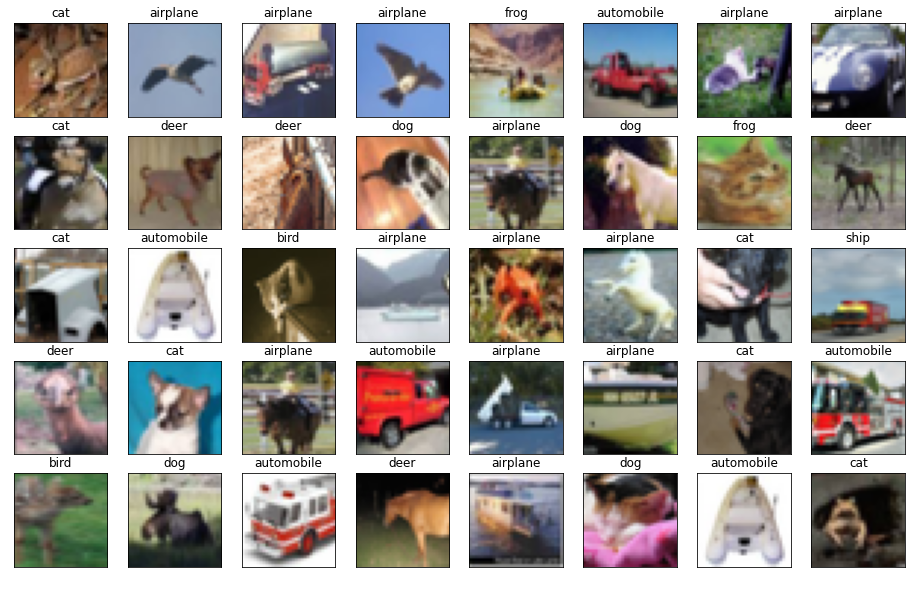

In [51]:
wrong_indices = predictions != np.array(testset.targets)

wrong_images = testset.data[wrong_indices]
wrong_labels = predictions[wrong_indices]
choosen_indices = np.random.choice(np.arange(len(wrong_images)), size=40)

images = wrong_images[choosen_indices]
wrong_label_predictions = wrong_labels[choosen_indices]
texts = [f'{labels[wrong_label_predictions[i]]}' for i in range(len(choosen_indices))]

columns = 8
rows = 5
fig = plt.figure(figsize=(2 * columns, 2 * rows))

for i in range(columns * rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title(texts[i])
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(images[i])

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.show()